In [1]:
import tensorflow as tf
import numpy as np
import os
import keras 

def add_gaussian_noise(image, mean=0.0, variance=0.2):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=variance**0.5, dtype=tf.float32)
    noisy_image = image + image*noise
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)
    return noisy_image

def process_image(image_path, image_size=(64, 64)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  # Use decode_png if needed
    image = tf.image.resize(image, image_size)
    image = image / 255.0
    #image = add_gaussian_noise(image)
    return image

def load_images_from_folder(folder_path, image_size=(64, 64)):
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, fname))]
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x: process_image(x))
    return dataset

def dataset_to_numpy(dataset):
    # Collect all images into a list
    images_list = []
    for image_batch in dataset:
        images_list.append(image_batch.numpy())
    # Concatenate all batches into a single NumPy array
    return np.concatenate(images_list, axis=0)

folder_path = 'C:\\Users\\bhask\\Desktop\\SAR\\s1'
dataset = load_images_from_folder(folder_path)

# Optionally, batch the dataset
dataset = dataset.batch(32)

# Convert dataset to NumPy array
original_images = dataset_to_numpy(dataset)
total_images = 4000
original_images = original_images[:total_images]

print(original_images.shape)  # Print the shape of the resulting NumPy array


(4000, 64, 64, 1)


In [3]:
from PIL import Image

In [4]:
noisy_images = []
for image in dataset:
    noisy_image = add_gaussian_noise(image)
    noisy_images.append(noisy_image)
noisy_images = np.concatenate(noisy_images, axis=0)
noisy_images = noisy_images[:total_images]
print(noisy_images.shape)

#save it to a folder as images
for i in range(noisy_images.shape[0]):
    img = noisy_images[i, :, :, 0]
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    img.save(f'noisy\\noisy_image_{i}.png')

#save it to a folder as images

for i in range(original_images.shape[0]):
    img = original_images[i, :, :, 0]
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    img.save(f'original\\original_image_{i}.png')




(4000, 64, 64, 1)


In [5]:
original_images.shape, noisy_images.shape

((4000, 64, 64, 1), (4000, 64, 64, 1))

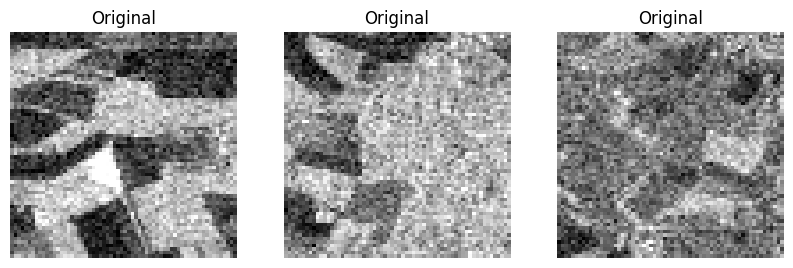

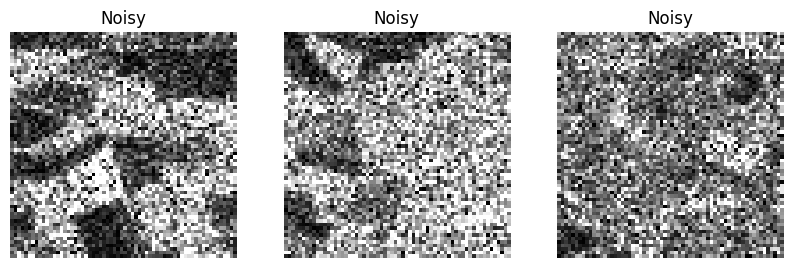

In [6]:
# diplay first 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i,image in enumerate(original_images[:3]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.axis('off')
    plt.title('Original')
plt.show()

plt.figure(figsize=(10, 10))
for i,image in enumerate(noisy_images[:3]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.axis('off')
    plt.title('Noisy')
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the autoencoder model for grayscale images
def DenoiserCNN(input_shape):
    model = models.Sequential()
    
    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Bottleneck
    model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
    
    # Decoder
    model.add(layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    # Output layer
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy','mae'])
    
    return model

# Example usage
input_shape = (64, 64, 1)  # Example input shape for grayscale images (height, width, channels)

model = DenoiserCNN(input_shape)
model.summary()


c:\Users\bhask\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,099,137 (11.82 MB)

 Trainable params: 3,099,137 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
np.max(original_images[0]), np.min(original_images[0])

(1.0, 0.0)

# we normalized our training data to 0-1  so output should be 0-1 so sigmoid
# Why not softmax ? (failed with softmax-- softmax output sum is always 1 (good for multiclass claissification) but not in sigmoid)
# Denosing is a regression problem

In [10]:
testing_first_data = 3600

Epoch 1/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 475ms/step - accuracy: 0.0041 - loss: 0.0353 - mae: 0.1502
Epoch 2/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 486ms/step - accuracy: 0.0058 - loss: 0.0212 - mae: 0.1146
Epoch 3/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 493ms/step - accuracy: 0.0060 - loss: 0.0195 - mae: 0.1096
Epoch 4/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 494ms/step - accuracy: 0.0061 - loss: 0.0186 - mae: 0.1073
Epoch 5/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 494ms/step - accuracy: 0.0060 - loss: 0.0182 - mae: 0.1059
Epoch 6/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 500ms/step - accuracy: 0.0055 - loss: 0.0178 - mae: 0.1048
Epoch 7/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - accuracy: 0.0058 - loss: 0.0175 - mae: 0.1040
Epoch 8/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 519ms/step - accuracy: 0.0063 - loss: 0.0173 - mae: 0.1033
Epoch 9/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 525ms/step - accuracy: 0.0061 - loss: 0.0172 - mae: 0.1033
Epoch 10/200
113/113 ━━━━━━━━━━━━━━━━━━━━ 59s 525ms/step - accur

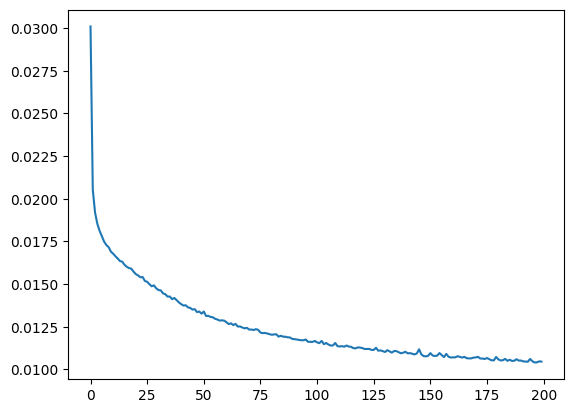

In [11]:

model.fit(noisy_images[:testing_first_data], original_images[:testing_first_data], epochs=200, batch_size=32)
#plotting the loss
plt.plot(model.history.history['loss'])
plt.show()
    

In [12]:
#save the model

keras.saving.save_model(model, 'DenoiserCNN_Adam.keras')

In [11]:

# Testing
denoised_images = model.predict(noisy_images[testing_first_data:])


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step


Average PSNR: 36.442066
Average MSE: 0.02632207
Average MAE: 0.12717235


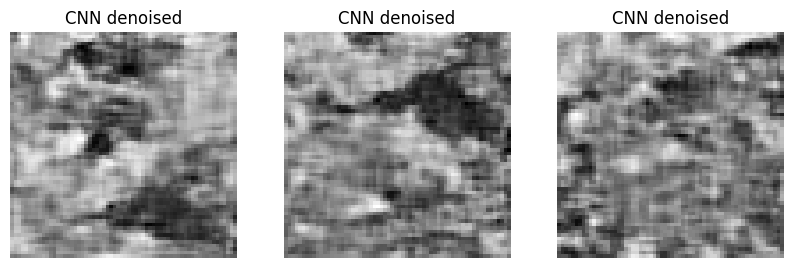

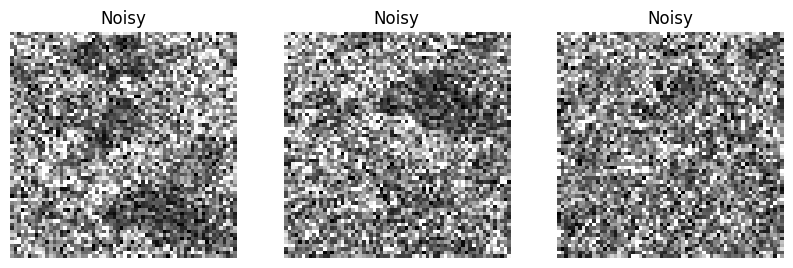

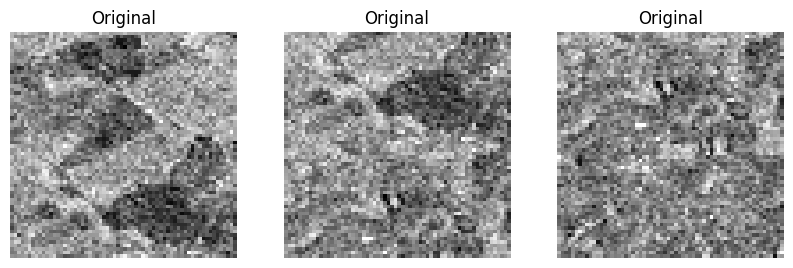

In [12]:
#Peak Signal to Noise Ratio (PSNR)
def psnr(original, denoised):
    max_val = 1.0
    mse = tf.reduce_mean(tf.square(original - denoised))
    return 20 * tf.math.log(max_val) - 10 * tf.math.log(mse)

psnr_values = []

for original, denoised in zip(original_images[testing_first_data:], denoised_images):
    psnr_values.append(psnr(original, denoised).numpy())

print('Average PSNR:', np.mean(psnr_values))

# Mean Squared Error (MSE)

mse_values = []

for original, denoised in zip(original_images[testing_first_data:], denoised_images):
    mse_values.append(tf.reduce_mean(tf.square(original - denoised)).numpy())

print('Average MSE:', np.mean(mse_values))


# Mean Absolute Error (MAE)

mae_values = []

for original, denoised in zip(original_images[testing_first_data:], denoised_images):
    mae_values.append(tf.reduce_mean(tf.abs(original - denoised)).numpy())

print('Average MAE:', np.mean(mae_values))

# Visualize

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(denoised_images[i]), cmap='gray')
    plt.axis('off')
    plt.title('CNN denoised')

plt.show()

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(noisy_images[testing_first_data+i]), cmap='gray')
    plt.axis('off')
    plt.title('Noisy')

plt.show()




plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(original_images[testing_first_data+i]), cmap='gray')
    plt.axis('off')
    plt.title('Original')

plt.show()


In [13]:
# load images from the folder noisy as PIL images 

from PIL import Image
import os

noisy_images = []
for i in range(testing_first_data,400):
    img = Image.open(f'noisy\\noisy_image_{i}.png')
    img = np.array(img)
    noisy_images.append(img)
noisy_images = np.array(noisy_images)

# load images from the folder original as PIL images 

original_images = []

for i in range(testing_first_data,400):
    img = Image.open(f'original\\original_image_{i}.png')
    img = np.array(img)
    original_images.append(img)
original_images = np.array(original_images)

In [14]:
import findpeaks
# window size
winsize = 15
# damping factor for frost
k_value1 = 2.0
# damping factor for lee enhanced
k_value2 = 1.0
# coefficient of variation of noise
cu_value = 0.25
# coefficient of variation for lee enhanced of noise
cu_lee_enhanced = 0.523
# max coefficient of variation for lee enhanced
cmax_value = 1.73

# Make grey image
# Scale 

In [15]:
noisy_images[0]

array([[ 96, 187,  49, ...,  89,  46, 169],
       [255, 155,  99, ..., 188,  28,  70],
       [199, 255, 176, ..., 144, 140, 132],
       ...,
       [148,  31, 255, ..., 157, 236,  36],
       [179,  76, 192, ...,  26, 165, 120],
       [146, 116, 101, ...,  48,  88, 110]], dtype=uint8)

In [16]:
#shape of the image

noisy_images[0].shape


(64, 64)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


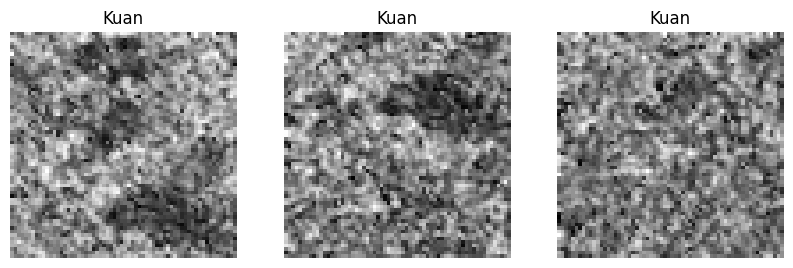

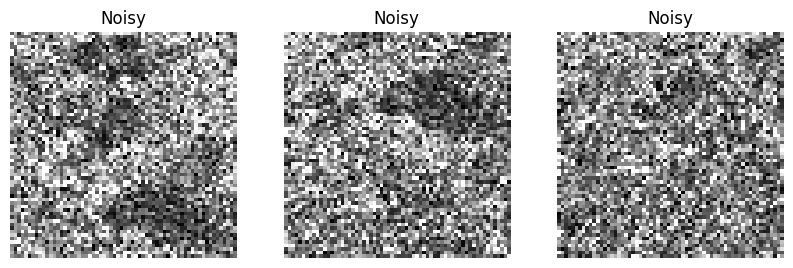

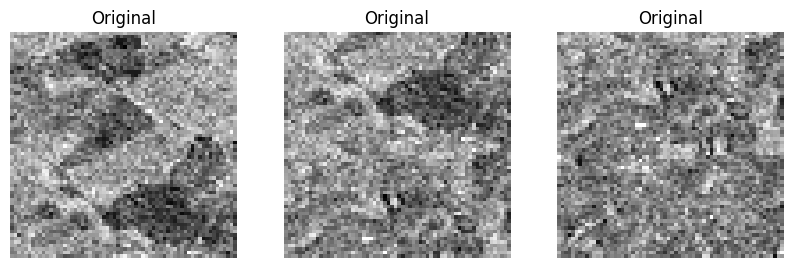

In [17]:
kuan_filtered_images = []
count = 0
for image in noisy_images:
    count += 1
    #between [0-255]
    kuan_filtered_image = findpeaks.kuan_filter(image, win_size=3, cu=0.5)
    kuan_filtered_images.append(kuan_filtered_image)
    print(count)


# Visualize the Kuan filtered

plt.figure(figsize=(10, 10))

for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(kuan_filtered_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Kuan')

plt.show()


plt.figure(figsize=(10, 10))

for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(noisy_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Noisy')

plt.show()


plt.figure(figsize=(10, 10))

for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Original')

plt.show()





In [18]:
import cv2
import numpy as np

def calculate_psnr(original_image, processed_image):
    # Ensure the images have the same shape
    assert original_image.shape == processed_image.shape, "Input images must have the same dimensions."
    
    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((original_image - processed_image) ** 2)
    if mse == 0:
        return float('inf')  # No noise
    
    # Calculate the maximum pixel value of the image
    max_pixel = 255.0
    
    # Calculate PSNR
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Load the original and processed images

# Calculate PSNR
psnr_values = []

for original, denoised in zip(original_images, kuan_filtered_images):
    psnr_values.append(calculate_psnr(original, denoised))

print('Average PSNR:', np.mean(psnr_values))



#mean squared error

def calculate_mse(original_image, processed_image):
    # Ensure the images have the same shape
    assert original_image.shape == processed_image.shape, "Input images must have the same dimensions."
    
    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((original_image - processed_image) ** 2)
    return mse

# Calculate MSE
mse_values = []

for original, denoised in zip(original_images, kuan_filtered_images):
    mse_values.append(calculate_mse(original, denoised))

print('Average MSE:', np.mean(mse_values))

#mean absolute error

def calculate_mae(original_image, processed_image):
    # Ensure the images have the same shape
    assert original_image.shape == processed_image.shape, "Input images must have the same dimensions."
    
    # Calculate the Mean Absolute Error (MAE)
    mae = np.mean(np.abs(original_image - processed_image))
    return mae

# Calculate MAE
mae_values = []

for original, denoised in zip(original_images, kuan_filtered_images):
    mae_values.append(calculate_mae(original, denoised))

print('Average MAE:', np.mean(mae_values))



Average PSNR: 16.48567616315916
Average MSE: 1470.216187756471
Average MAE: 29.60338985558712


In [19]:




# Denoising
# fastnl
#img_fastnl = findpeaks.stats.denoise(img, method='fastnl', window=winsize)
# bilateral
#img_bilateral = findpeaks.stats.denoise(img, method='bilateral', window=winsize)
# frost filter
#image_frost = findpeaks.frost_filter(img, damping_factor=k_value1, win_size=winsize)
# kuan filter
#image_kuan = findpeaks.kuan_filter(img, win_size=winsize, cu=cu_value)
# lee filter
#image_lee = findpeaks.lee_filter(img, win_size=winsize, cu=cu_value)
# lee enhanced filter
#image_lee_enhanced = findpeaks.lee_enhanced_filter(img, win_size=winsize, k=k_value2, cu=cu_lee_enhanced, cmax=cmax_value)
# mean filter
#image_mean = findpeaks.mean_filter(img, win_size=winsize)
# median filter
#image_median = findpeaks.median_filter(img, win_size=winsize)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


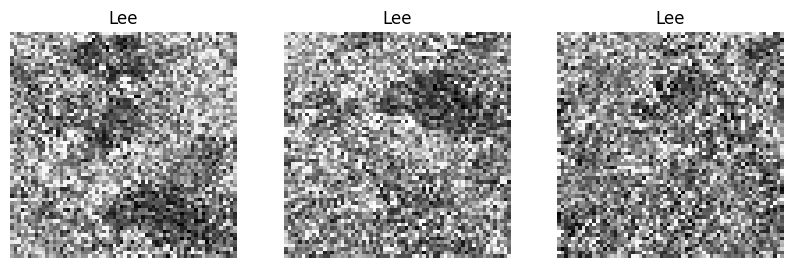

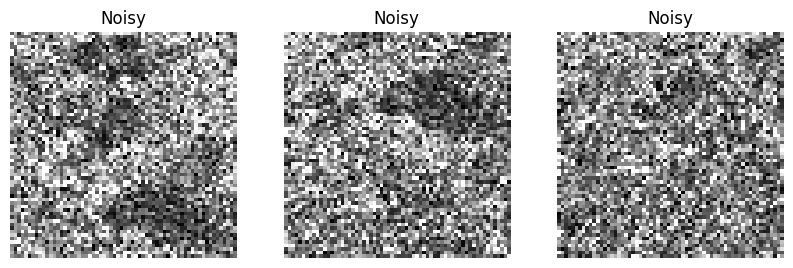

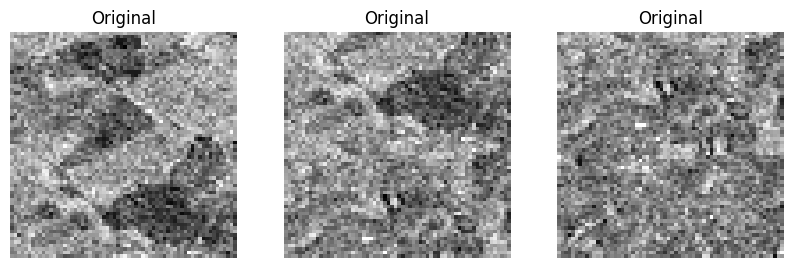

Average PSNR: 15.456089394995976
Average MSE: 1859.1256904987374
Average MAE: 32.90622533933081


In [20]:
lee_filtered_images = []
count = 0
for image in noisy_images:
    count += 1
    #between [0-255]
    lee_filtered_image = findpeaks.lee_filter(image, win_size=winsize, cu=cu_value)
    lee_filtered_images.append(lee_filtered_image)
    print(count)


# Visualize the Kuan filtered

plt.figure(figsize=(10, 10))

for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(lee_filtered_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Lee')

plt.show()


plt.figure(figsize=(10, 10))

for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(noisy_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Noisy')

plt.show()



plt.figure(figsize=(10, 10))
for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.axis('off')
    plt.title('Original')

plt.show()



import cv2
import numpy as np

def calculate_psnr(original_image, processed_image):
    # Ensure the images have the same shape
    assert original_image.shape == processed_image.shape, "Input images must have the same dimensions."
    
    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((original_image - processed_image) ** 2)
    if mse == 0:
        return float('inf')  # No noise
    
    # Calculate the maximum pixel value of the image
    max_pixel = 255.0
    
    # Calculate PSNR
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Load the original and processed images

# Calculate PSNR
psnr_values = []

for original, denoised in zip(original_images, lee_filtered_images):
    psnr_values.append(calculate_psnr(original, denoised))

print('Average PSNR:', np.mean(psnr_values))



# Calculate MSE
mse_values = []

for original, denoised in zip(original_images, lee_filtered_images):
    mse_values.append(calculate_mse(original, denoised))

print('Average MSE:', np.mean(mse_values))

# Calculate MAE

mae_values = []



for original, denoised in zip(original_images, lee_filtered_images):
    mae_values.append(calculate_mae(original, denoised))

print('Average MAE:', np.mean(mae_values))













In [21]:
frost_filtered_images = []
count = 0
for image in noisy_images:
    count += 1
    #between [0-255]
    frost_filtered_image = findpeaks.frost_filter(image, damping_factor=k_value1, win_size=winsize)


    frost_filtered_images.append(frost_filtered_image)
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


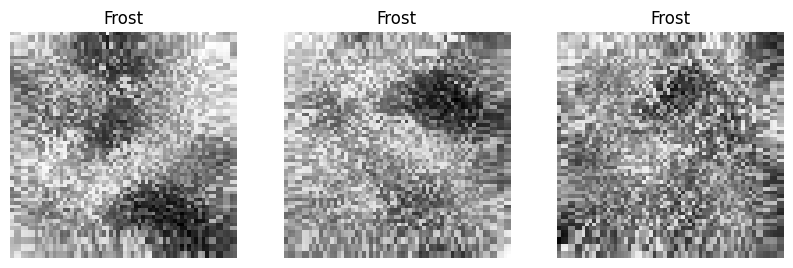

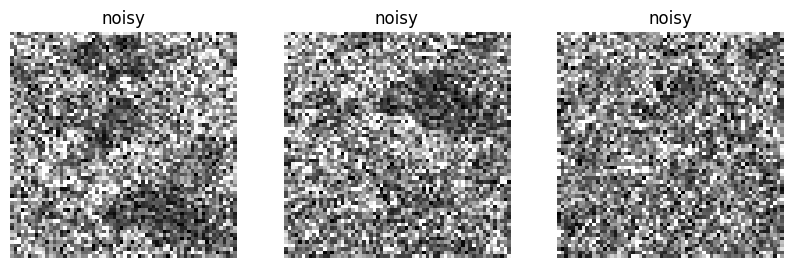

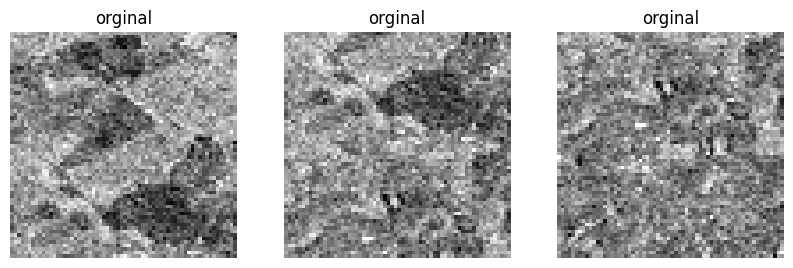

Average PSNR: 28.141711309048908
Average MSE: 99.75933406328915
Average MAE: 121.59596206202652


In [22]:



# Visualize the Kuan filtered

plt.figure(figsize=(10, 10))

for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(frost_filtered_images[i], cmap='gray')
    plt.axis('off')
    plt.title("Frost")

plt.show()

plt.figure(figsize=(10, 10))

for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(noisy_images[i], cmap='gray')
    plt.axis('off')
    plt.title("noisy")

plt.show()

plt.figure(figsize=(10, 10))

for i in range(3):

    plt.subplot(3, 3, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.axis('off')
    plt.title("orginal")

plt.show()

import cv2
import numpy as np

def calculate_psnr(original_image, processed_image):
    # Ensure the images have the same shape
    assert original_image.shape == processed_image.shape, "Input images must have the same dimensions."
    
    # Calculate the Mean Squared Error (MSE)
    mse = np.mean((original_image - processed_image) ** 2)
    if mse == 0:
        return float('inf')  # No noise
    
    # Calculate the maximum pixel value of the image
    max_pixel = 255.0
    
    # Calculate PSNR
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Load the original and processed images

# Calculate PSNR
psnr_values = []

for original, denoised in zip(original_images, frost_filtered_images):
    psnr_values.append(calculate_psnr(original, denoised))

print('Average PSNR:', np.mean(psnr_values))


# Calculate MSE

mse_values = []

for original, denoised in zip(original_images, frost_filtered_images):
    mse_values.append(calculate_mse(original, denoised))

print('Average MSE:', np.mean(mse_values))



# Calculate MAE

mae_values = []

for original, denoised in zip(original_images, frost_filtered_images):
    mae_values.append(calculate_mae(original, denoised))

print('Average MAE:', np.mean(mae_values))



